In [1]:
%load_ext tensorboard

In [2]:
import os
import numpy as np
import pandas as pd

import sklearn
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedShuffleSplit

import tensorflow.keras as keras

In [3]:
core_path = os.getcwd()
asteroids_df = pd.read_pickle(os.path.join(core_path, "data/lvl2/", "asteroids.pkl"))

In [4]:
asteroids_X = np.array([k["Reflectance_norm550nm"].tolist() for k in asteroids_df["SpectrumDF"]])
asteroids_y = np.array(asteroids_df["Main Group"].to_list())

In [5]:
asteroids_X = np.expand_dims(asteroids_X, axis=2)

In [6]:
label_encoder = preprocessing.OneHotEncoder(sparse_output=True)
asteroids_oh_y = label_encoder.fit_transform(asteroids_y.reshape(-1,1)).toarray()

In [7]:
oh_init = [1, 0, 0, 0]
for n in range(4):
    oh_class = oh_init[-n:] + oh_init[:-n]
    org_class = label_encoder.inverse_transform([oh_class])
    print(f"One-Hot-Vector {oh_class} corresponds to the Main Group: {org_class[0][0]}")

One-Hot-Vector [1, 0, 0, 0] corresponds to the Main Group: C
One-Hot-Vector [0, 1, 0, 0] corresponds to the Main Group: Other
One-Hot-Vector [0, 0, 1, 0] corresponds to the Main Group: S
One-Hot-Vector [0, 0, 0, 1] corresponds to the Main Group: X


In [8]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

# Create a simple, single train / test split
for train_index, test_index in sss.split(asteroids_X, asteroids_y):
    
    X_train, X_test = asteroids_X[train_index], asteroids_X[test_index]
    y_train, y_test = asteroids_oh_y[train_index], asteroids_oh_y[test_index]

In [9]:
from sklearn.utils.class_weight import compute_sample_weight
sample_weight = compute_sample_weight("balanced", y=y_train)

In [ ]:
import keras_tuner as kt

es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

n_inputs = asteroids_X.shape[1]

normalizer = keras.layers.Normalization(axis=1)
normalizer.adapt(X_train)

def create_model(hp):
    input_layer = keras.Input(shape=(n_inputs, 1))
    norm_layer = normalizer(input_layer)

    hidden_layer = keras.layers.Conv1D(filters=hp.Int("1_filter",
                                                      min_value=8,
                                                      max_value=32,
                                                      step=8),
                                                      activation="relu",
                                                      kernel_size=hp.Int("1_kernal",
                                                                         min_value=3,
                                                                         max_value=7,
                                                                         step=1))(norm_layer)
    hidden_layer = keras.layers.MaxPooling1D(pool_size=2)(hidden_layer)

    hidden_layer = keras.layers.Conv1D(filters=hp.Int("2_filter",
                                                      min_value=16,
                                                      max_value=128,
                                                      step=16),
                                                      activation="relu",
                                                      kernel_size=hp.Int("2_kernal",
                                                                         min_value=3,
                                                                         max_value=7,
                                                                         step=1))(hidden_layer)
    hidden_layer = keras.layers.MaxPooling1D(pool_size=2)(hidden_layer)

    hidden_layer = keras.layers.Flatten()(hidden_layer)

    hidden_layer = keras.layers.Dense(hp.Int("units",
                                            min_value=8,
                                            max_value=64,
                                            step=8),
                                            activation="relu")(hidden_layer)
    
    if hp.Boolean("dropout"):
        hidden_layer = keras.layers.Dropout(hp.Float("dr_rate",
                                                     min_value=0.1,
                                                     max_value=0.5,
                                                     step=0.1))(hidden_layer)
        
    output_layer = keras.layers.Dense(4, activation="softmax")(hidden_layer)

    model = keras.models.Model(inputs=input_layer, outputs=output_layer)

    model.compile(optimizer="adam", loss="categorical_crossentropy")

    return model



In [11]:
tuner = kt.BayesianOptimization(
    create_model,
    objective="val_loss",
    max_trials=25,
    num_initial_points=8,
    directory="kt_results_bayes",          # 🔹 NEW directory
    project_name="asteroid_spectra_conv1d_bayes",  # 🔹 NEW project
    overwrite=False                        # 🔹 do NOT replace existing runs
)

end_epoch = 400
batch_size = 32

tuner.search(
    X_train,
    y_train,
    batch_size=batch_size,
    verbose=1,
    validation_split=0.25,
    epochs=end_epoch,
    sample_weight=sample_weight,
    callbacks=[
        es_callback,
        keras.callbacks.TensorBoard(
            log_dir="logs_bayes/fit"        # 🔹 separate TensorBoard logs
        )
    ]
)


Trial 25 Complete [00h 00m 13s]
val_loss: 0.0746375322341919

Best val_loss So Far: 0.05926122888922691
Total elapsed time: 00h 07m 23s


In [12]:
model = tuner.get_best_models()[0]

c:\Users\Shade\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [13]:
tuner.results_summary()

Results summary
Results in kt_results_bayes\asteroid_spectra_conv1d_bayes
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 14 summary
Hyperparameters:
1_filter: 32
1_kernal: 6
2_filter: 128
2_kernal: 4
units: 24
dropout: False
dr_rate: 0.30000000000000004
Score: 0.05926122888922691

Trial 20 summary
Hyperparameters:
1_filter: 24
1_kernal: 6
2_filter: 128
2_kernal: 3
units: 48
dropout: False
dr_rate: 0.2
Score: 0.05949926748871803

Trial 15 summary
Hyperparameters:
1_filter: 8
1_kernal: 7
2_filter: 96
2_kernal: 7
units: 56
dropout: True
dr_rate: 0.5
Score: 0.06017491966485977

Trial 06 summary
Hyperparameters:
1_filter: 32
1_kernal: 4
2_filter: 48
2_kernal: 3
units: 24
dropout: True
dr_rate: 0.1
Score: 0.06595650315284729

Trial 18 summary
Hyperparameters:
1_filter: 32
1_kernal: 7
2_filter: 112
2_kernal: 4
units: 24
dropout: False
dr_rate: 0.1
Score: 0.06674106419086456

Trial 19 summary
Hyperparameters:
1_filter: 16
1_kernal: 4
2_filter: 128
2_kernal: 3
units: 

In [14]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 49, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 49, 1)          │            99 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 44, 32)         │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 22, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 19, 128)        │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 24)             │        27,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,607 (174.25 KB)

 Trainable params: 44,508 (173.86 KB)

 Non-trainable params: 99 (400.00 B)

In [15]:
tuner.oracle.get_best_trials()[0].trial_id

'14'

In [17]:
%tensorboard --logdir logs_bayes/  --host localhost

Reusing TensorBoard on port 6007 (pid 21964), started 0:00:02 ago. (Use '!kill 21964' to kill it.)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


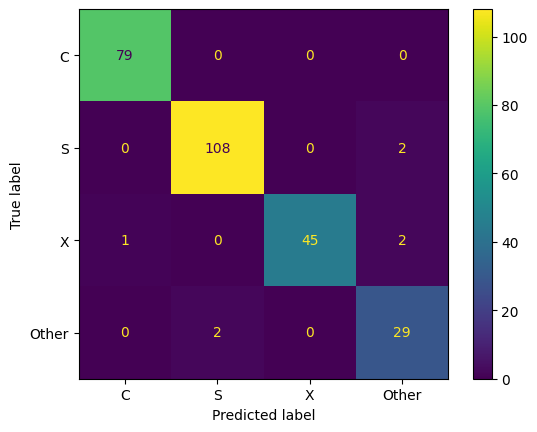

In [18]:
# Compute class probabilities
y_test_prop_pred = model.predict(X_test)

# Compute the corresponding one-hot classes
y_test_oh_pred = np.zeros_like(y_test_prop_pred)
y_test_oh_pred[np.arange(len(y_test_prop_pred)), y_test_prop_pred.argmax(1)] = 1

# Re-transform the classes now!
asteroid_classes_test = label_encoder.inverse_transform(y_test).reshape(1, -1)[0]
asteroid_classes_test_pred = label_encoder.inverse_transform(y_test_oh_pred).reshape(1, -1)[0]

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Compute the confusion matrix
conf_mat = confusion_matrix(asteroid_classes_test,
                            asteroid_classes_test_pred,
                            labels=["C", "S", "X", "Other"])

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                              display_labels=["C", "S", "X", "Other"])
disp.plot()
# plt.show()


In [19]:
f1_score = round(sklearn.metrics.f1_score(asteroid_classes_test,
                                          asteroid_classes_test_pred,
                                          average="weighted"), 3)
print(f"F1 Score: {f1_score}")

F1 Score: 0.974
